In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa as lr
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.regularizers import l1_l2
import keras
from tensorflow import keras

from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l1
from tensorflow.keras import utils
from sklearn.utils import compute_class_weight

In [ ]:
! pip install -q kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download dmitrybabko/speech-emotion-recognition-en
! unzip speech-emotion-recognition-en.zip
! pip install tensorflow-io

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  inflating: Crema/1088_TSI_DIS_XX.wav  
  inflating: Crema/1088_TSI_FEA_XX.wav  
  infl

In [ ]:
def LoadAudio(Crema):
    emotions = []
    Audio_List=[]
    samp_freq=[]
    
    for wav in os.listdir(Crema):
        path=Crema+"/"+wav
        audio,sampling_freq=lr.load(path,sr=16000)
        yt, index = lr.effects.trim(audio, top_db=60)       
        
        if len(yt) > (3*16000):
            yt = yt[:3*16000]
        else:
            padding = (3*16000) - len(yt)
            offset = padding // 2
            yt = np.pad(yt, (offset,3*16000- len(yt) - offset), 'constant')

        mean = np.mean(yt)
        std = np.std(yt)
        out = np.ones( (len(yt)) ) 
        yt= np.divide((yt - mean),std,out=out, where=std!=0)

        Audio_List.append(yt)
        samp_freq.append(sampling_freq)

        info = wav.partition(".wav")[0].split("_")
        if info[2] == 'SAD':
            emotions.append(0)
        elif info[2] == 'ANG':
            emotions.append(1)
        elif info[2] == 'DIS':
            emotions.append(2)
        elif info[2] == 'FEA':
            emotions.append(3)
        elif info[2] == 'HAP':
            emotions.append(4)
        elif info[2] == 'NEU':
            emotions.append(5)
        else:
            emotions.append(6)
            
    return Audio_List,samp_freq,emotions

In [ ]:
Audio_List,samp_freq,Labels=  LoadAudio('Crema')

print(len(Audio_List))
print(len(Labels))

trainSet,testSet, labels_train, labels_test = train_test_split(Audio_List, Labels, test_size=0.30, random_state=42)
trainSet, valSet, labels_train, labels_val = train_test_split(trainSet, labels_train, test_size=0.05, random_state=42)
print(len(trainSet))
print(len(valSet))

train_Aug=[]
for i in range(len(trainSet)):
  train_Aug.append(trainSet[i])

print(len(train_Aug))
print(len(labels_train))

7442
7442
4948
261
4948
4948


In [ ]:
import tensorflow_io as tfio

def mel_spectrogram(train_Aug):   
    S = lr.feature.melspectrogram(train_Aug, sr=16000, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db=lr.power_to_db(S, ref=np.max)
    return mel_spec_db

In [ ]:
train_set_spectorgram = np.zeros((len(train_Aug)*2,128,94))
for i in range(len(train_Aug)):
  train_set_spectorgram[i]= mel_spectrogram(train_Aug[i])

[Text(0.5, 1.0, 'Mel-frequency spectrogram before Freq Mask')]

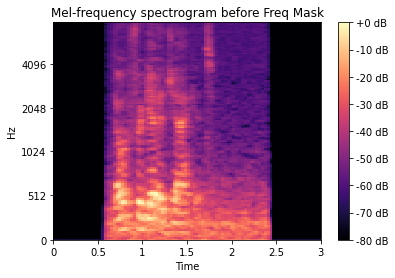

In [ ]:
fig, ax = plt.subplots()
mel_spectrogram = librosa.display.specshow(train_set_spectorgram[0], x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax)
fig.colorbar(mel_spectrogram, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram before Freq Mask')

In [ ]:
def freq_mask(mel_spec_db):    
    freq_mask = tfio.audio.freq_mask(mel_spec_db, param=10)
    return freq_mask
j=0
for i in range(len(train_Aug),len(train_Aug)*2):
  train_set_spectorgram[i]= freq_mask(train_set_spectorgram[j])
  labels_train.append(labels_train[j])
  j+=1

In [ ]:
val_set_spectorgram = np.zeros((len(valSet),128,94))  # mel spectrogram val 
for audio in range(len(valSet)):
  S = lr.feature.melspectrogram(valSet[audio], sr=16000, n_fft=2048, hop_length=512, n_mels=128)
  mel_spec_db=lr.power_to_db(S, ref=np.max)
  val_set_spectorgram[audio] = mel_spec_db

test_set_spectorgram = np.zeros((len(testSet),128,94))  # mel spectrogram test 
for audio in range(len(testSet)):
  S = lr.feature.melspectrogram(testSet[audio], sr=16000, n_fft=2048, hop_length=512, n_mels=128)
  mel_spec_db=lr.power_to_db(S, ref=np.max)
  test_set_spectorgram[audio] = mel_spec_db

In [ ]:
train_set_spectorgram = train_set_spectorgram[:,:,:,np.newaxis]
print(train_set_spectorgram.shape)
val_set_spectorgram = val_set_spectorgram[:,:,:,np.newaxis]
print(val_set_spectorgram.shape)
test_set_spectorgram = test_set_spectorgram[:,:,:,np.newaxis]
print(test_set_spectorgram.shape)

(9896, 128, 94, 1)
(261, 128, 94, 1)
(2233, 128, 94, 1)


In [ ]:
nclass =len(np.unique(Labels))
inp = Input(shape=(128, 94, 1))

norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(norm_inp)
img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
img_1 = Dropout(rate=0.1)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
img_1 = Dropout(rate=0.1)(img_1)
img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
img_1 = GlobalMaxPool2D()(img_1)
img_1 = Dropout(rate=0.1)(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.compile( loss = losses.sparse_categorical_crossentropy,optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 94, 1)]      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 94, 1)       4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 92, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 90, 16)       2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 30, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 41, 30, 16)        0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping

classWeight = compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(labels_train), 
    y =labels_train) 
classWeight = dict(enumerate(classWeight))
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100)

model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=16, epochs=1000, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)),class_weight=classWeight,callbacks=[lr_reduce, es])
score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)

Epoch 1/1000
619/619 [==============================] - 32s 27ms/step - loss: 24.0919 - accuracy: 0.1722 - val_loss: 23.0267 - val_accuracy: 0.1916 - lr: 1.0000e-05
Epoch 2/1000
619/619 [==============================] - 16s 26ms/step - loss: 22.7170 - accuracy: 0.1778 - val_loss: 21.7769 - val_accuracy: 0.1801 - lr: 1.0000e-05
Epoch 3/1000
619/619 [==============================] - 16s 26ms/step - loss: 21.4429 - accuracy: 0.1917 - val_loss: 20.6061 - val_accuracy: 0.2452 - lr: 1.0000e-05
Epoch 4/1000
619/619 [==============================] - 16s 26ms/step - loss: 20.2668 - accuracy: 0.1960 - val_loss: 19.5758 - val_accuracy: 0.2146 - lr: 1.0000e-05
Epoch 5/1000
619/619 [==============================] - 16s 26ms/step - loss: 19.2041 - accuracy: 0.2142 - val_loss: 18.6070 - val_accuracy: 0.2299 - lr: 1.0000e-05
Epoch 6/1000
619/619 [==============================] - 16s 27ms/step - loss: 18.2183 - accuracy: 0.2271 - val_loss: 17.7853 - val_accuracy: 0.2222 - lr: 1.0000e-05
Epoch 7/10

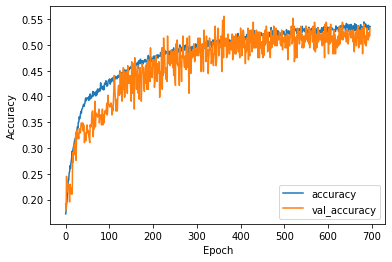

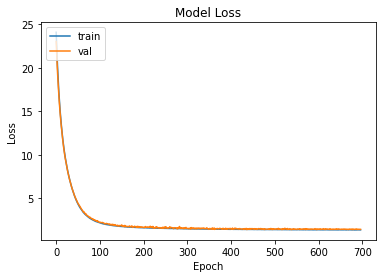

In [ ]:
plt.plot( model_history.history['accuracy'], label='accuracy')
plt.plot( model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

              precision    recall  f1-score   support

           0       0.47      0.74      0.57       407
           1       0.69      0.67      0.68       379
           2       0.47      0.47      0.47       371
           3       0.56      0.20      0.30       378
           4       0.51      0.30      0.38       381
           5       0.46      0.70      0.55       317

    accuracy                           0.51      2233
   macro avg       0.53      0.51      0.49      2233
weighted avg       0.53      0.51      0.49      2233



val accuracy: 53.2567024230957
train accuracy: 56.40662908554077
test accuracy 51.14196148678908




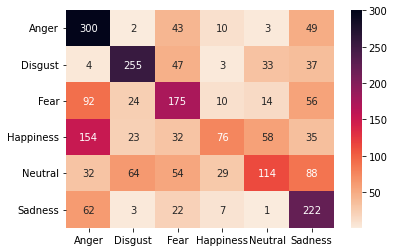

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(train_set_spectorgram), np.array(labels_train), verbose=0)
y_pred = model.predict(test_set_spectorgram)

report=metrics.classification_report(labels_test,np.argmax(y_pred,axis=1)) 
print(report)


matrix = metrics.confusion_matrix(labels_test ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

print("\n")
print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test,np.argmax(y_pred,axis=1))*100)
print("\n")

In [ ]:
nclass =len(np.unique(Labels))
inp = Input(shape=(128, 94, 1))

norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(norm_inp)
img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
img_1 = Dropout(rate=0.1)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
img_1 = Dropout(rate=0.1)(img_1)
img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
img_1 = GlobalMaxPool2D()(img_1)
img_1 = Dropout(rate=0.1)(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.compile( loss = losses.sparse_categorical_crossentropy,optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 94, 1)]      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 94, 1)       4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 92, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 90, 16)       2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 30, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 41, 30, 16)        0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping

classWeight = compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(labels_train), 
    y =labels_train) 
classWeight = dict(enumerate(classWeight))
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100)

model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=32, epochs=1000, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)),class_weight=classWeight,callbacks=[lr_reduce, es])
score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)

Epoch 1/1000
310/310 [==============================] - 26s 35ms/step - loss: 24.3459 - accuracy: 0.1873 - val_loss: 23.7049 - val_accuracy: 0.1724 - lr: 1.0000e-05
Epoch 2/1000
310/310 [==============================] - 10s 32ms/step - loss: 23.7238 - accuracy: 0.2081 - val_loss: 23.2196 - val_accuracy: 0.1609 - lr: 1.0000e-05
Epoch 3/1000
310/310 [==============================] - 10s 32ms/step - loss: 23.1311 - accuracy: 0.2216 - val_loss: 22.6697 - val_accuracy: 0.1571 - lr: 1.0000e-05
Epoch 4/1000
310/310 [==============================] - 10s 32ms/step - loss: 22.5220 - accuracy: 0.2273 - val_loss: 22.0822 - val_accuracy: 0.1724 - lr: 1.0000e-05
Epoch 5/1000
310/310 [==============================] - 10s 32ms/step - loss: 21.9799 - accuracy: 0.2327 - val_loss: 21.5350 - val_accuracy: 0.2184 - lr: 1.0000e-05
Epoch 6/1000
310/310 [==============================] - 10s 32ms/step - loss: 21.4032 - accuracy: 0.2453 - val_loss: 20.9994 - val_accuracy: 0.2261 - lr: 1.0000e-05
Epoch 7/10

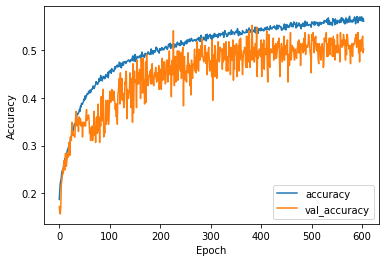

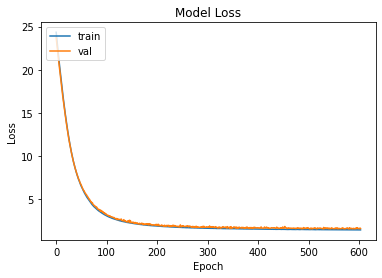

In [ ]:
plt.plot( model_history.history['accuracy'], label='accuracy')
plt.plot( model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

              precision    recall  f1-score   support

           0       0.47      0.75      0.58       404
           1       0.76      0.48      0.59       386
           2       0.43      0.51      0.47       372
           3       0.51      0.40      0.45       367
           4       0.57      0.40      0.47       393
           5       0.54      0.59      0.56       311

    accuracy                           0.52      2233
   macro avg       0.55      0.52      0.52      2233
weighted avg       0.55      0.52      0.52      2233



val accuracy: 50.191569328308105
train accuracy: 57.083672285079956
test accuracy 52.21674876847291




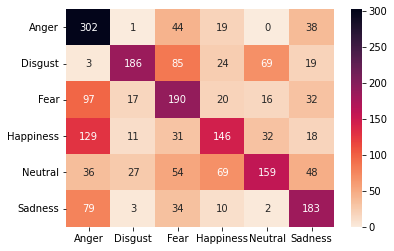

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(train_set_spectorgram), np.array(labels_train), verbose=0)
y_pred = model.predict(test_set_spectorgram)

report=metrics.classification_report(labels_test,np.argmax(y_pred,axis=1)) 
print(report)


matrix = metrics.confusion_matrix(labels_test ,np.argmax(y_pred,axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

print("\n")
print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test,np.argmax(y_pred,axis=1))*100)
print("\n")